GOAL:

1. Classification - Toxicity
  - This is completed in two steps
    - Step 1: Classifying if the comment is toxic or not
    - Step 2: If the comment is toxic, classify it on the basis of its toxicity into low, moderate or high

Process:
1. Reading in the data [Sampled data in this case]
2. EDA
3. Apply Pre-processing techniques
4. Using TFIDF vector to classify if the comment is toxic or not
5. Using Keras DNN and TFIDF to classify the toxic comments on the basis of their toxicity



In [ ]:
import pandas as pd
import numpy as np
import math
import io
from tqdm import tqdm
tqdm.pandas()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# We created a sampled data, reading in the sample data
# Before running this, select "Add shortcut to Drive" under the 'NLP Project' folder options
data_train = pd.read_csv('/content/drive/My Drive/NLP Project/data_train_sampled.csv')
data_test = pd.read_csv('/content/drive/My Drive/NLP Project/data_test_sampled.csv')

In [ ]:
#looking at the number of records for both datasets
print(data_train.shape)
print(data_test.shape)

(18049, 46)
(1946, 46)


In [ ]:
#only picking in relevant columns from the dataset
data_train = data_train[['id','comment_text','toxicity']]
data_test = data_test[['id','comment_text','toxicity']]

In [ ]:
# To create a label class - toxic or non-toxic
binning_options_label = dict(
      bins = [0,0.25,2], 
      include_lowest = True, 
      right = False, 
      labels = list(range(2))
)

# To convert continuos Toxicity into Bins - -1 for non-toxic, we will only use this to filter data, 0,1,2 to for toxic indicating low medium high respectively
binning_options_bins = dict(
      bins = [0,0.25,0.5,0.75,2], 
      include_lowest = True, 
      right = False, 
      labels = list(range(-1,3))
)

In [ ]:
#applying the pd cut functions to create label columns
data_train['toxicity_label'] = pd.cut(data_train.toxicity, **binning_options_label).astype(int)
data_test['toxicity_label'] = pd.cut(data_test.toxicity, **binning_options_label).astype(int)

data_train['toxicity_bins'] = pd.cut(data_train.toxicity, **binning_options_bins).astype(int)
data_test['toxicity_bins'] = pd.cut(data_test.toxicity, **binning_options_bins).astype(int)

Exploratory Data Analysis

In [ ]:
#Percentage split between Toxic and Non-Toxic comments
round(data_train.groupby(['toxicity_label'])['toxicity'].count()/data_train.shape[0]*100,2)

toxicity_label
0    85.46
1    14.54
Name: toxicity, dtype: float64

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
toxicity = round(data_train.groupby(['toxicity_label'])['toxicity'].count()/data_train.shape[0]*100,2)
toxicity

toxicity_label
0    85.46
1    14.54
Name: toxicity, dtype: float64

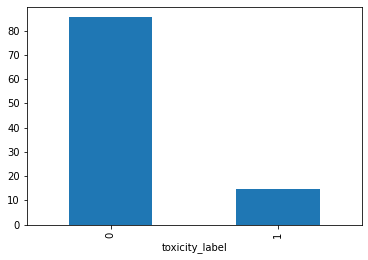

In [ ]:
toxicity.plot.bar()

In [ ]:
#Percentage split between Toxic- categorized by low medium high and Non-Toxic comments
round(data_train.groupby(['toxicity_bins'])['toxicity'].count()/data_train.shape[0]*100,2)

toxicity_bins
-1    85.46
 0     6.93
 1     5.61
 2     2.00
Name: toxicity, dtype: float64

In [ ]:
#Percentage split between Toxic- categorized by low medium high comments
round(data_train[data_train.toxicity_bins != -1].groupby(['toxicity_bins'])['toxicity'].count()/data_train[data_train.toxicity_bins != -1].shape[0]*100,2)

toxicity_bins
0    47.68
1    38.57
2    13.76
Name: toxicity, dtype: float64

In [ ]:
toxic_category = round(data_train[data_train.toxicity_bins != -1].groupby(['toxicity_bins'])['toxicity'].count()/data_train[data_train.toxicity_bins != -1].shape[0]*100,2)
toxic_category

toxicity_bins
0    47.68
1    38.57
2    13.76
Name: toxicity, dtype: float64

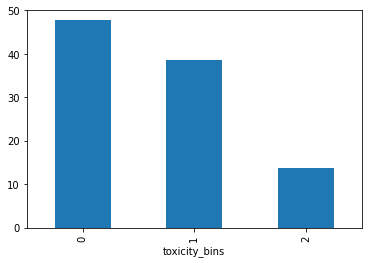

In [ ]:
toxic_category.plot.bar()

In [ ]:
#forward look ahead on test data - not included in the presentation
round(data_test.groupby(['toxicity_label'])['toxicity'].count()/data_test.shape[0]*100,2)

toxicity_label
0    84.22
1    15.78
Name: toxicity, dtype: float64

In [ ]:
#forward look ahead on test data - not included in the presentation
round(data_test.groupby(['toxicity_bins'])['toxicity'].count()/data_test.shape[0]*100,2)

toxicity_bins
-1    84.22
 0     7.55
 1     6.42
 2     1.80
Name: toxicity, dtype: float64

In [ ]:
#forward look ahead on test data - not included in the presentation
round(data_test[data_test.toxicity_bins != -1].groupby(['toxicity_bins'])['toxicity'].count()/data_test[data_test.toxicity_bins != -1].shape[0]*100,2)

toxicity_bins
0    47.88
1    40.72
2    11.40
Name: toxicity, dtype: float64

Data Preprocessing

In [ ]:
!pip install textacy | tail -1

In [ ]:
!python3 -m spacy download en_core_web_md | tail -1

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2022-12-14 20:19:49.536971: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
from gensim.parsing.preprocessing import remove_stopwords

from textacy.preprocessing.replace import urls, hashtags, numbers, emails, emojis, currency_symbols
from textacy.preprocessing.remove import punctuation
from textacy import extract

pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)

import re
from bs4 import BeautifulSoup

import spacy
import en_core_web_md
nlp = spacy.load('en_core_web_md')

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
#a function to decontract the text
def decontracted(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)
    
    phrase = re.sub(r"\r", " ", phrase)
    phrase = re.sub(r"\n", " ", phrase)
    phrase = re.sub(r'\"', " ", phrase)

    return phrase

#a function which uses textacy to do text preprocessing
def preprocessedtext(df):
  df['processed_comment'] = df['comment_text'].apply(decontracted).apply(urls).apply(hashtags).apply(numbers).apply(currency_symbols).apply(emojis).apply(emails).apply(punctuation)
  return df['processed_comment']


In [ ]:
data_train['processed_comment'] = preprocessedtext(data_train[['comment_text']])
data_test['processed_comment'] = preprocessedtext(data_test[['comment_text']])

<ipython-input-17-7108d7c752d3>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['processed_comment'] = df['comment_text'].apply(decontracted).apply(urls).apply(hashtags).apply(numbers).apply(currency_symbols).apply(emojis).apply(emails).apply(punctuation)


In [ ]:
#a function which returns lemmatized text after stopwords removal
def analyze_text(text):
    doc = nlp(text)
    doc_upd = []
    for token in doc:
      if not token.is_stop:
        if token.text[0] =="_":
          doc_upd.append(token.text)
          continue
        doc_upd.append(token.lemma_)
    return ' '.join(doc_upd)


In [ ]:
#a function which returns text after named entity removal
def replace_ner(text):
    clean_text = text
    doc = nlp(text)
    for ent in reversed(doc.ents):
        clean_text = clean_text[:ent.start_char] + "_" + ent.label_ + "_ " + clean_text[ent.end_char:]
    return clean_text

In [ ]:
#applying text preprocessing transformation
data_train['lemmatized_comment'] = data_train['processed_comment'].progress_apply(analyze_text).progress_apply(replace_ner)
data_test['lemmatized_comment'] = data_test['processed_comment'].progress_apply(analyze_text).progress_apply(replace_ner)

100%|██████████| 1946/1946 [00:25<00:00, 76.22it/s]


In [ ]:
data_train.head()

,id,comment_text,toxicity,toxicity_label,toxicity_bins,processed_comment,lemmatized_comment
0,5334578,"Only evidence the commandments were revealed before the exile is a document written long after the exile. They weren't revealed by God to anyone on a mountain in Sinai, although you are free to argue they were revealed by God using the Babylonians.\n\nOnly evidence for what Jesus said is a collection of documents written after he was gone by people who had their own agendas. Can get the outl...",0.0,0,-1,Only evidence the commandments were revealed before the exile is a document written long after the exile They were not revealed by God to anyone on a mountain in Sinai although you are free to argue they were revealed by God using the Babylonians Only evidence for what Jesus said is a collection of documents written after he was gone by people who had their own agendas Can get the outli...,evidence commandment reveal exile document write long exile reveal God mountain _GPE_ free argue reveal God Babylonians evidence _PERSON_ say collection document write go people agenda outline _PERSON_ teach specificity suspect free apply definition label wish need
1,6057166,"No one should ever rely on anything written in the comments section. However, I used to work in this area and there is caselaw backing that up. A registered security and a nominal payment should suffice.",0.0,0,-1,No one should ever rely on anything written in the comments section However I used to work in this area and there is caselaw backing that up A registered security and a nominal payment should suffice,rely write comment _LAW_ work area caselaw backing register security nominal payment suffice
2,567211,"Just what Oregon needs; more outside influence on our legislature, fighting the citizens of Oregon instead of standing up for them.",0.0,0,-1,Just what Oregon needs more outside influence on our legislature fighting the citizens of Oregon instead of standing up for them,_GPE_ need outside influence legislature fight citizen _GPE_ instead stand
3,5543002,"staph - I hope you do understand that Canada is the only G7 country without vaccine injury compensation program. All other developed countries have institutionalized compensation to the victims of vaccine injuries. Just because we don't have this here, it doesn't mean vaccine injuries don't happen. It means that the injured people are on their own and government and medical community washes...",0.0,0,-1,staph I hope you do understand that Canada is the only G7 country without vaccine injury compensation program All other developed countries have institutionalized compensation to the victims of vaccine injuries Just because we do not have this here it does not mean vaccine injuries do not happen It means that the injured people are on their own and government and medical community was...,staph hope understand _ORG_ country vaccine injury compensation program develop country institutionalize compensation victim vaccine injury mean vaccine injury happen mean injured people government medical community wash hand mean vaccine entirely safe program States pay _MONEY_ injured people wish vaccine safe tell wish actually research find vaccine injury compen...
4,5808880,"I understand what the writer is saying, but it's too late to save a 40 or 50 year old racist or neo-nazi. Hatred is all they have left and there is nothing left to save. We must be very vigilant with these types and ostracize and shame them as examples to others heading down that dark, menacing path. We can save the kids, but the older haters are well beyond the point of no return. We can ...",0.4,1,0,I understand what the writer is saying but it s too late to save a NUMBER or NUMBER year old racist or neo nazi Hatred is all they have left and there is nothing left to save We must be very vigilant with these types and ostracize and shame them as examples to others heading down that dark menacing path We can save the kids but the older haters are well beyo

In [ ]:
data_train.tail()

,id,comment_text,toxicity,toxicity_label,toxicity_bins,processed_comment,lemmatized_comment
18044,5319739,Where did you get the idea that anyone would be forced to carry or take the training? It's entirely voluntary and always has been.,0.000000,0,-1,Where did you get the idea that anyone would be forced to carry or take the training It s entirely voluntary and always has been,idea force carry training s entirely voluntary
18045,852189,The MSM said that about Trump as well.,0.000000,0,-1,The MSM said that about Trump as well,MSM say _PERSON_
18046,936562,"Hi, gtm. Wise words. Nope...no rust. Not sitting idle, although not much on the road. We bought this pm.",0.166667,0,-1,Hi gtm Wise words Nope no rust Not sitting idle although not much on the road We bought this pm,hi gtm wise word Nope rust sit idle road buy pm
18047,5239147,"Perfect illustration of what's wrong with politics/politicians, on both sides. Schumer's display of disingenuous behavior would be laughable except for the fact that guys like him run our country. They let party loyalty take precedence over what's best for the country.",0.000000,0,-1,Perfect illustration of what s wrong with politics politicians on both sides Schumer s display of disingenuous behavior would be laughable except for the fact that guys like him run our country They let party loyalty take precedence over what s best for the country,perfect illustration s wrong politic politician side _PERSON_ s display disingenuous behavior laughable fact guy like run country let party loyalty precedence s good country
18048,262545,"You mean...no, it can't be...that the organic ice cream isn't made in small batches, using salt and ice in little ice cream makers that are hand cranked by elves?",0.000000,0,-1,You mean no it can not be that the organic ice cream is not made in small batches using salt and ice in little ice cream makers that are hand cranked by elves,mean organic ice cream small batch salt ice little ice cream maker hand crank elf


In [ ]:
data_train.to_pickle('/content/drive/My Drive/NLP Project/pickled_dataframes/data_train.pickle')
data_test.to_pickle('/content/drive/My Drive/NLP Project/pickled_dataframes/data_test.pickle')

In [ ]:
data_train = pd.read_pickle('/content/drive/My Drive/NLP Project/pickled_dataframes/data_train.pickle')
data_test = pd.read_pickle('/content/drive/My Drive/NLP Project/pickled_dataframes/data_test.pickle')

MODEL BUILDING - NODE 1 (TOXIC or NON-TOXIC)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plot


In [ ]:
#why using TFIDF, does not make sense to use count vectorizer since TFIDF is a better bag of words model. Training Sequential word embedding model on 18K rows of data with multiple epochs took a huge amount of time

tfidf = TfidfVectorizer(ngram_range = (1,3), max_features=10000)

#applying similar transformation after training model on test dataset
X_train = tfidf.fit_transform(data_train.lemmatized_comment)
X_test = tfidf.transform(data_test.lemmatized_comment)

feature_names = tfidf.get_feature_names()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#creating y train and y test labels
y_train = data_train.toxicity_label
y_test = data_test.toxicity_label

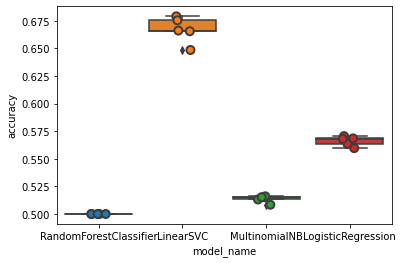

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

#importing different classification models to see which model perform better on toxicity prediction
models = [RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0), LinearSVC(), MultinomialNB(), LogisticRegression(random_state=0)]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train, y_train, scoring='balanced_accuracy', cv=CV) #using balanced accuracy due to class imbalance
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()


In [ ]:
#SVC is the winner
#we understand that models do not have v good accuracy on default threshold
cv_df.groupby('model_name').accuracy.mean()11

model_name
LinearSVC                 0.666984
LogisticRegression        0.566053
MultinomialNB             0.513623
RandomForestClassifier    0.500000
Name: accuracy, dtype: float64

Text(0, 0.5, 'Precision/Recall')

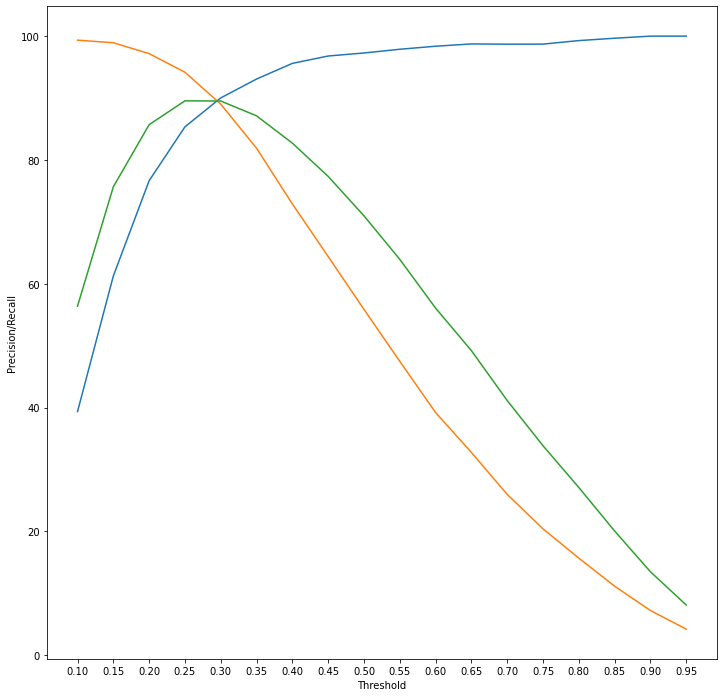

In [ ]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

svm = LinearSVC()
model = CalibratedClassifierCV(svm) 

model.fit(X_train, y_train)
y_pred = model.predict(X_train)
y_pred_prob = model.predict_proba(X_train)

threshold = list(np.arange(0.1, 1, 0.05)) 
score_df = pd.DataFrame(index = threshold, columns = ['Precision','Recall','F1Score'])

for t in threshold:
    y_pred = (model.predict_proba(X_train)[:, 1] > t).astype('float')
    recall = round(recall_score(y_train, y_pred)*100,2)
    precision = round(precision_score(y_train, y_pred)*100,2)
    f1 = round(f1_score(y_train, y_pred)*100,2)
    score_df.loc[t,'Precision'] = precision
    score_df.loc[t,'Recall'] = recall
    score_df.loc[t,'F1Score'] = f1


fig, ax = plt.subplots(figsize=(12,12))
ax.plot(score_df.Precision)
ax.plot(score_df.Recall)
ax.plot(score_df.F1Score)
ax.set_xticks(threshold)
ax.set_xlabel('Threshold')
ax.set_ylabel('Precision/Recall')

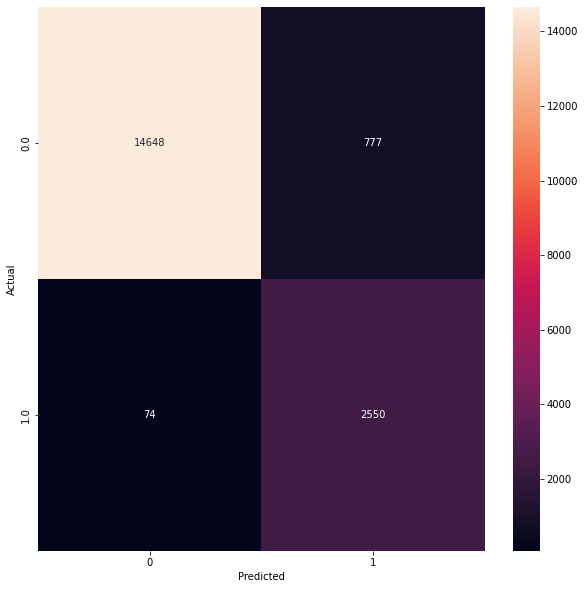

In [ ]:
t = 0.2
y_pred = (model.predict_proba(X_train)[:, 1] > t).astype('float')
conf_matrix = confusion_matrix(y_train, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels = np.unique(y_train), yticklabels = np.unique(y_pred))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

F1 score at  0.2 is  55.36
Precision score at  0.2 is  49.87
Recall score at  0.2 is  62.21


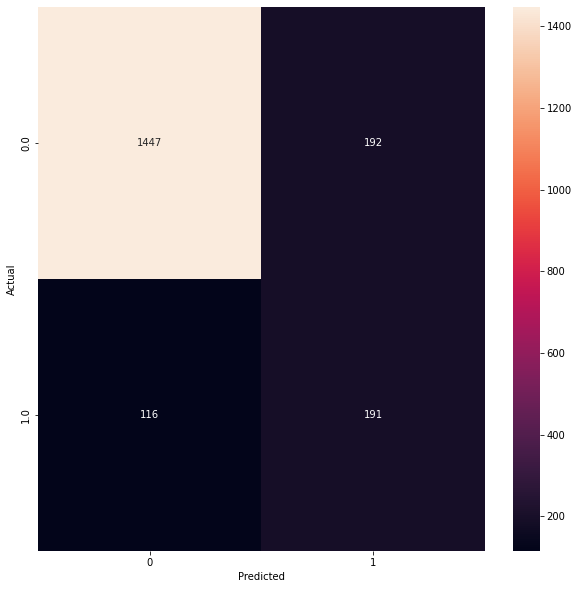

In [ ]:
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)


y_pred = (model.predict_proba(X_test)[:, 1] > t).astype('float')
conf_matrix = confusion_matrix(y_test, y_pred)
print("F1 score at ", t, "is ", round(f1_score(y_test, y_pred)*100,2))
print("Precision score at ", t, "is ", round(precision_score(y_test, y_pred)*100,2))
print("Recall score at ", t, "is ", round(recall_score(y_test, y_pred)*100,2))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels = np.unique(y_test), yticklabels = np.unique(y_pred))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [ ]:
y_test.shape,y_pred.shape

((1946,), (1946,))

MODEL BUILDING - NODE 2 (LEVEL OF TOXICITY)

In [ ]:
#removing non-toxic comments for training and test data
data_train_node2 = data_train[data_train.toxicity_bins != -1]
data_test_node2 = data_test[data_test.toxicity_bins != -1]

In [ ]:
!pip install tensorflow keras | tail -1

In [ ]:
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from numpy import array

Option 1: Word Embeddings

In [ ]:
#creating a keras tokenizer and adding word encodings based on the comment
t = Tokenizer()
t.fit_on_texts(data_train_node2['lemmatized_comment'])
vocab_size = len(t.word_index) + 1
encoded_train = t.texts_to_sequences(data_train_node2['lemmatized_comment'])
max_length = max([len(x) for x in encoded_train])
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
data_train_node2['WordEncodings'] = pd.Series(padded_train.tolist())


<ipython-input-36-6614e0e35ca6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train_node2['WordEncodings'] = pd.Series(padded_train.tolist())


In [ ]:
#applying same transformation to test dataset
encoded_test = t.texts_to_sequences(data_test_node2['lemmatized_comment'])
padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')
data_test_node2['WordEncodings'] = pd.Series(padded_test.tolist())

<ipython-input-37-ce8afaf6b677>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_node2['WordEncodings'] = pd.Series(padded_test.tolist())


In [ ]:
#using the glove embeddings
f = open('/content/drive/My Drive/NLP Project/glove.6B.100d.txt')
embeddings_index = dict()
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [ ]:
#creating an embedding matrix cache for a word embedding
embedding_matrix = zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: # check that it is an actual word that we have embeddings for
        embedding_matrix[i] = embedding_vector


In [ ]:
import tensorflow as tf

In [ ]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

#creating a keras model to see the parameters count
def make_model(metrics=METRICS):

  model = Sequential()
  e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False)
  model.add(e)
  model.add(Flatten())
  model.add(Dense(3, activation='softmax'))
  model.add(Flatten())
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=metrics)

  return model

In [ ]:
#creating an early stopping call back function
early_stopping = tf.keras.callbacks.EarlyStopping( monitor='val_prc', verbose=1, restore_best_weights=True)

In [ ]:
model = make_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 107, 100)          885300    
                                                                 
 flatten_4 (Flatten)         (None, 10700)             0         
                                                                 
 dense_2 (Dense)             (None, 3)                 32103     
                                                                 
 flatten_5 (Flatten)         (None, 3)                 0         
                                                                 
Total params: 917,403
Trainable params: 32,103
Non-trainable params: 885,300
_________________________________________________________________


In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
#fitting the model to training dataset - running multiple epochs
model.fit(padded_train, to_categorical(data_train_node2.toxicity_bins), epochs=100, verbose=1, callbacks=[early_stopping])

Epoch 1/100
76/82 [==========================>...] - ETA: 0s - loss: 1.8371 - tp: 872.0000 - fp: 1146.0000 - tn: 3718.0000 - fn: 1560.0000 - accuracy: 0.6291 - precision: 0.4321 - recall: 0.3586 - auc: 0.6101 - prc: 0.4204

82/82 [==============================] - 3s 6ms/step - loss: 1.8415 - tp: 948.0000 - fp: 1238.0000 - tn: 4010.0000 - fn: 1676.0000 - accuracy: 0.6298 - precision: 0.4337 - recall: 0.3613 - auc: 0.6107 - prc: 0.4220
Epoch 2/100
76/82 [==========================>...] - ETA: 0s - loss: 0.8447 - tp: 1550.0000 - fp: 667.0000 - tn: 4197.0000 - fn: 882.0000 - accuracy: 0.7877 - precision: 0.6991 - recall: 0.6373 - auc: 0.8587 - prc: 0.7613

82/82 [==============================] - 1s 6ms/step - loss: 0.8623 - tp: 1671.0000 - fp: 725.0000 - tn: 4523.0000 - fn: 953.0000 - accuracy: 0.7868 - precision: 0.6974 - recall: 0.6368 - auc: 0.8563 - prc: 0.7575
Epoch 3/100
80/82 [============================>.] - ETA: 0s - loss: 0.6417 - tp: 1842.0000 - fp: 539.0000 - tn: 4581.0000 - fn: 718.0000 - accuracy: 0.8363 - precision: 0.7736 - recall: 0.7195 - auc: 0.9068 - prc: 0.8422

82/82 [==============================] - 1s 6ms/step - loss: 0.6450 - tp: 1884.0000 - fp: 555.0000 - tn: 4693.0000 - fn: 740.0000 - accuracy: 0.8355 - precision: 0.7724 - recall: 0.7180 - auc: 0.9060 - prc: 0.8408
Epoch 4/100
75/82 [==========================>...] - ETA: 0s - loss: 0.4767 - tp: 1884.0000 - fp: 375.0000 - tn: 4425.0000 - fn: 516.0000 - accuracy: 0.8763 - precision: 0.8340 - recall: 0.7850 - auc: 0.9431 - prc: 0.9013

82/82 [==============================] - 0s 6ms/step - loss: 0.4856 - tp: 2049.0000 - fp: 418.0000 - tn: 4830.0000 - fn: 575.0000 - accuracy: 0.8739 - precision: 0.8306 - recall: 0.7809 - auc: 0.9413 - prc: 0.8992
Epoch 5/100
74/82 [==========================>...] - ETA: 0s - loss: 0.3913 - tp: 1919.0000 - fp: 323.0000 - tn: 4413.0000 - fn: 449.0000 - accuracy: 0.8913 - precision: 0.8559 - recall: 0.8104 - auc: 0.9606 - prc: 0.9315

82/82 [==============================] - 0s 6ms/step - loss: 0.4063 - tp: 2115.0000 - fp: 364.0000 - tn: 4884.0000 - fn: 509.0000 - accuracy: 0.8891 - precision: 0.8532 - recall: 0.8060 - auc: 0.9580 - prc: 0.9274
Epoch 6/100
80/82 [============================>.] - ETA: 0s - loss: 0.3248 - tp: 2192.0000 - fp: 229.0000 - tn: 4891.0000 - fn: 368.0000 - accuracy: 0.9223 - precision: 0.9054 - recall: 0.8562 - auc: 0.9735 - prc: 0.9525

82/82 [==============================] - 0s 5ms/step - loss: 0.3270 - tp: 2244.0000 - fp: 239.0000 - tn: 5009.0000 - fn: 380.0000 - accuracy: 0.9214 - precision: 0.9037 - recall: 0.8552 - auc: 0.9731 - prc: 0.9519
Epoch 7/100
76/82 [==========================>...] - ETA: 0s - loss: 0.2755 - tp: 2145.0000 - fp: 211.0000 - tn: 4653.0000 - fn: 287.0000 - accuracy: 0.9317 - precision: 0.9104 - recall: 0.8820 - auc: 0.9808 - prc: 0.9651

82/82 [==============================] - 0s 6ms/step - loss: 0.2870 - tp: 2302.0000 - fp: 234.0000 - tn: 5014.0000 - fn: 322.0000 - accuracy: 0.9294 - precision: 0.9077 - recall: 0.8773 - auc: 0.9794 - prc: 0.9626
Epoch 8/100
78/82 [===========================>..] - ETA: 0s - loss: 0.2494 - tp: 2227.0000 - fp: 175.0000 - tn: 4817.0000 - fn: 269.0000 - accuracy: 0.9407 - precision: 0.9271 - recall: 0.8922 - auc: 0.9853 - prc: 0.9734

82/82 [==============================] - 0s 5ms/step - loss: 0.2514 - tp: 2339.0000 - fp: 186.0000 - tn: 5062.0000 - fn: 285.0000 - accuracy: 0.9402 - precision: 0.9263 - recall: 0.8914 - auc: 0.9849 - prc: 0.9728
Epoch 9/100
76/82 [==========================>...] - ETA: 0s - loss: 0.2182 - tp: 2209.0000 - fp: 138.0000 - tn: 4726.0000 - fn: 223.0000 - accuracy: 0.9505 - precision: 0.9412 - recall: 0.9083 - auc: 0.9896 - prc: 0.9807

82/82 [==============================] - 0s 6ms/step - loss: 0.2148 - tp: 2384.0000 - fp: 149.0000 - tn: 5099.0000 - fn: 240.0000 - accuracy: 0.9506 - precision: 0.9412 - recall: 0.9085 - auc: 0.9898 - prc: 0.9810
Epoch 10/100
72/82 [=========================>....] - ETA: 0s - loss: 0.1936 - tp: 2137.0000 - fp: 114.0000 - tn: 4494.0000 - fn: 167.0000 - accuracy: 0.9593 - precision: 0.9494 - recall: 0.9275 - auc: 0.9920 - prc: 0.9848

82/82 [==============================] - 0s 5ms/step - loss: 0.1983 - tp: 2424.0000 - fp: 134.0000 - tn: 5114.0000 - fn: 200.0000 - accuracy: 0.9576 - precision: 0.9476 - recall: 0.9238 - auc: 0.9913 - prc: 0.9836
Epoch 11/100
82/82 [==============================] - ETA: 0s - loss: 0.1785 - tp: 2478.0000 - fp: 103.0000 - tn: 5145.0000 - fn: 146.0000 - accuracy: 0.9684 - precision: 0.9601 - recall: 0.9444 - auc: 0.9935 - prc: 0.9875

82/82 [==============================] - 0s 6ms/step - loss: 0.1785 - tp: 2478.0000 - fp: 103.0000 - tn: 5145.0000 - fn: 146.0000 - accuracy: 0.9684 - precision: 0.9601 - recall: 0.9444 - auc: 0.9935 - prc: 0.9875
Epoch 12/100
82/82 [==============================] - ETA: 0s - loss: 0.1812 - tp: 2441.0000 - fp: 125.0000 - tn: 5123.0000 - fn: 183.0000 - accuracy: 0.9609 - precision: 0.9513 - recall: 0.9303 - auc: 0.9932 - prc: 0.9870

82/82 [==============================] - 0s 5ms/step - loss: 0.1812 - tp: 2441.0000 - fp: 125.0000 - tn: 5123.0000 - fn: 183.0000 - accuracy: 0.9609 - precision: 0.9513 - recall: 0.9303 - auc: 0.9932 - prc: 0.9870
Epoch 13/100
80/82 [============================>.] - ETA: 0s - loss: 0.1612 - tp: 2412.0000 - fp: 105.0000 - tn: 5015.0000 - fn: 148.0000 - accuracy: 0.9671 - precision: 0.9583 - recall: 0.9422 - auc: 0.9946 - prc: 0.9895

82/82 [==============================] - 0s 5ms/step - loss: 0.1609 - tp: 2471.0000 - fp: 108.0000 - tn: 5140.0000 - fn: 153.0000 - accuracy: 0.9668 - precision: 0.9581 - recall: 0.9417 - auc: 0.9946 - prc: 0.9896
Epoch 14/100
81/82 [============================>.] - ETA: 0s - loss: 0.1553 - tp: 2453.0000 - fp: 93.0000 - tn: 5091.0000 - fn: 139.0000 - accuracy: 0.9702 - precision: 0.9635 - recall: 0.9464 - auc: 0.9951 - prc: 0.9904

82/82 [==============================] - 0s 5ms/step - loss: 0.1549 - tp: 2484.0000 - fp: 94.0000 - tn: 5154.0000 - fn: 140.0000 - accuracy: 0.9703 - precision: 0.9635 - recall: 0.9466 - auc: 0.9951 - prc: 0.9904
Epoch 15/100
82/82 [==============================] - ETA: 0s - loss: 0.1421 - tp: 2496.0000 - fp: 88.0000 - tn: 5160.0000 - fn: 128.0000 - accuracy: 0.9726 - precision: 0.9659 - recall: 0.9512 - auc: 0.9959 - prc: 0.9920

82/82 [==============================] - 0s 5ms/step - loss: 0.1421 - tp: 2496.0000 - fp: 88.0000 - tn: 5160.0000 - fn: 128.0000 - accuracy: 0.9726 - precision: 0.9659 - recall: 0.9512 - auc: 0.9959 - prc: 0.9920
Epoch 16/100
77/82 [===========================>..] - ETA: 0s - loss: 0.1280 - tp: 2375.0000 - fp: 60.0000 - tn: 4868.0000 - fn: 89.0000 - accuracy: 0.9798 - precision: 0.9754 - recall: 0.9639 - auc: 0.9967 - prc: 0.9934

82/82 [==============================] - 0s 6ms/step - loss: 0.1292 - tp: 2527.0000 - fp: 67.0000 - tn: 5181.0000 - fn: 97.0000 - accuracy: 0.9792 - precision: 0.9742 - recall: 0.9630 - auc: 0.9967 - prc: 0.9934
Epoch 17/100
72/82 [=========================>....] - ETA: 0s - loss: 0.1188 - tp: 2233.0000 - fp: 48.0000 - tn: 4560.0000 - fn: 71.0000 - accuracy: 0.9828 - precision: 0.9790 - recall: 0.9692 - auc: 0.9974 - prc: 0.9945

82/82 [==============================] - 0s 5ms/step - loss: 0.1176 - tp: 2544.0000 - fp: 56.0000 - tn: 5192.0000 - fn: 80.0000 - accuracy: 0.9827 - precision: 0.9785 - recall: 0.9695 - auc: 0.9973 - prc: 0.9946
Epoch 18/100
74/82 [==========================>...] - ETA: 0s - loss: 0.1112 - tp: 2308.0000 - fp: 39.0000 - tn: 4697.0000 - fn: 60.0000 - accuracy: 0.9861 - precision: 0.9834 - recall: 0.9747 - auc: 0.9975 - prc: 0.9948

82/82 [==============================] - 0s 6ms/step - loss: 0.1137 - tp: 2548.0000 - fp: 51.0000 - tn: 5197.0000 - fn: 76.0000 - accuracy: 0.9839 - precision: 0.9804 - recall: 0.9710 - auc: 0.9974 - prc: 0.9948
Epoch 19/100
76/82 [==========================>...] - ETA: 0s - loss: 0.1021 - tp: 2379.0000 - fp: 38.0000 - tn: 4826.0000 - fn: 53.0000 - accuracy: 0.9875 - precision: 0.9843 - recall: 0.9782 - auc: 0.9980 - prc: 0.9958

82/82 [==============================] - 0s 5ms/step - loss: 0.1036 - tp: 2560.0000 - fp: 46.0000 - tn: 5202.0000 - fn: 64.0000 - accuracy: 0.9860 - precision: 0.9823 - recall: 0.9756 - auc: 0.9979 - prc: 0.9957
Epoch 20/100
73/82 [=========================>....] - ETA: 0s - loss: 0.0985 - tp: 2288.0000 - fp: 30.0000 - tn: 4642.0000 - fn: 48.0000 - accuracy: 0.9889 - precision: 0.9871 - recall: 0.9795 - auc: 0.9981 - prc: 0.9959

82/82 [==============================] - 0s 5ms/step - loss: 0.0991 - tp: 2567.0000 - fp: 37.0000 - tn: 5211.0000 - fn: 57.0000 - accuracy: 0.9881 - precision: 0.9858 - recall: 0.9783 - auc: 0.9981 - prc: 0.9960
Epoch 21/100
71/82 [========================>.....] - ETA: 0s - loss: 0.0983 - tp: 2217.0000 - fp: 35.0000 - tn: 4509.0000 - fn: 55.0000 - accuracy: 0.9868 - precision: 0.9845 - recall: 0.9758 - auc: 0.9980 - prc: 0.9957

82/82 [==============================] - 0s 5ms/step - loss: 0.0954 - tp: 2564.0000 - fp: 39.0000 - tn: 5209.0000 - fn: 60.0000 - accuracy: 0.9874 - precision: 0.9850 - recall: 0.9771 - auc: 0.9981 - prc: 0.9960
Epoch 22/100
77/82 [===========================>..] - ETA: 0s - loss: 0.0949 - tp: 2410.0000 - fp: 42.0000 - tn: 4886.0000 - fn: 54.0000 - accuracy: 0.9870 - precision: 0.9829 - recall: 0.9781 - auc: 0.9980 - prc: 0.9958

82/82 [==============================] - 1s 6ms/step - loss: 0.0947 - tp: 2566.0000 - fp: 46.0000 - tn: 5202.0000 - fn: 58.0000 - accuracy: 0.9868 - precision: 0.9824 - recall: 0.9779 - auc: 0.9980 - prc: 0.9959
Epoch 23/100
74/82 [==========================>...] - ETA: 0s - loss: 0.0899 - tp: 2328.0000 - fp: 25.0000 - tn: 4711.0000 - fn: 40.0000 - accuracy: 0.9909 - precision: 0.9894 - recall: 0.9831 - auc: 0.9983 - prc: 0.9964

82/82 [==============================] - 0s 6ms/step - loss: 0.0883 - tp: 2580.0000 - fp: 28.0000 - tn: 5220.0000 - fn: 44.0000 - accuracy: 0.9909 - precision: 0.9893 - recall: 0.9832 - auc: 0.9984 - prc: 0.9966
Epoch 24/100
81/82 [============================>.] - ETA: 0s - loss: 0.0863 - tp: 2545.0000 - fp: 36.0000 - tn: 5148.0000 - fn: 47.0000 - accuracy: 0.9893 - precision: 0.9861 - recall: 0.9819 - auc: 0.9984 - prc: 0.9966

82/82 [==============================] - 0s 5ms/step - loss: 0.0868 - tp: 2575.0000 - fp: 37.0000 - tn: 5211.0000 - fn: 49.0000 - accuracy: 0.9891 - precision: 0.9858 - recall: 0.9813 - auc: 0.9984 - prc: 0.9966
Epoch 25/100
79/82 [===========================>..] - ETA: 0s - loss: 0.0837 - tp: 2492.0000 - fp: 31.0000 - tn: 5025.0000 - fn: 36.0000 - accuracy: 0.9912 - precision: 0.9877 - recall: 0.9858 - auc: 0.9984 - prc: 0.9966

82/82 [==============================] - 0s 6ms/step - loss: 0.0836 - tp: 2586.0000 - fp: 32.0000 - tn: 5216.0000 - fn: 38.0000 - accuracy: 0.9911 - precision: 0.9878 - recall: 0.9855 - auc: 0.9984 - prc: 0.9966
Epoch 26/100
77/82 [===========================>..] - ETA: 0s - loss: 0.0758 - tp: 2425.0000 - fp: 28.0000 - tn: 4900.0000 - fn: 39.0000 - accuracy: 0.9909 - precision: 0.9886 - recall: 0.9842 - auc: 0.9989 - prc: 0.9976

82/82 [==============================] - 0s 6ms/step - loss: 0.0829 - tp: 2579.0000 - fp: 33.0000 - tn: 5215.0000 - fn: 45.0000 - accuracy: 0.9901 - precision: 0.9874 - recall: 0.9829 - auc: 0.9985 - prc: 0.9968
Epoch 27/100
74/82 [==========================>...] - ETA: 0s - loss: 0.0801 - tp: 2334.0000 - fp: 23.0000 - tn: 4713.0000 - fn: 34.0000 - accuracy: 0.9920 - precision: 0.9902 - recall: 0.9856 - auc: 0.9985 - prc: 0.9967

82/82 [==============================] - 0s 6ms/step - loss: 0.0782 - tp: 2585.0000 - fp: 26.0000 - tn: 5222.0000 - fn: 39.0000 - accuracy: 0.9917 - precision: 0.9900 - recall: 0.9851 - auc: 0.9986 - prc: 0.9970
Epoch 28/100
73/82 [=========================>....] - ETA: 0s - loss: 0.0778 - tp: 2302.0000 - fp: 22.0000 - tn: 4650.0000 - fn: 34.0000 - accuracy: 0.9920 - precision: 0.9905 - recall: 0.9854 - auc: 0.9984 - prc: 0.9967

82/82 [==============================] - 0s 5ms/step - loss: 0.0768 - tp: 2583.0000 - fp: 28.0000 - tn: 5220.0000 - fn: 41.0000 - accuracy: 0.9912 - precision: 0.9893 - recall: 0.9844 - auc: 0.9986 - prc: 0.9969
Epoch 29/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0736 - tp: 2400.0000 - fp: 25.0000 - tn: 4839.0000 - fn: 32.0000 - accuracy: 0.9922 - precision: 0.9897 - recall: 0.9868 - auc: 0.9985 - prc: 0.9969

82/82 [==============================] - 0s 6ms/step - loss: 0.0726 - tp: 2590.0000 - fp: 26.0000 - tn: 5222.0000 - fn: 34.0000 - accuracy: 0.9924 - precision: 0.9901 - recall: 0.9870 - auc: 0.9986 - prc: 0.9971
Epoch 30/100
81/82 [============================>.] - ETA: 0s - loss: 0.0684 - tp: 2561.0000 - fp: 21.0000 - tn: 5163.0000 - fn: 31.0000 - accuracy: 0.9933 - precision: 0.9919 - recall: 0.9880 - auc: 0.9986 - prc: 0.9971

82/82 [==============================] - 0s 5ms/step - loss: 0.0680 - tp: 2593.0000 - fp: 21.0000 - tn: 5227.0000 - fn: 31.0000 - accuracy: 0.9934 - precision: 0.9920 - recall: 0.9882 - auc: 0.9987 - prc: 0.9972
Epoch 31/100
77/82 [===========================>..] - ETA: 0s - loss: 0.0632 - tp: 2444.0000 - fp: 14.0000 - tn: 4914.0000 - fn: 20.0000 - accuracy: 0.9954 - precision: 0.9943 - recall: 0.9919 - auc: 0.9987 - prc: 0.9972

82/82 [==============================] - 1s 6ms/step - loss: 0.0645 - tp: 2599.0000 - fp: 18.0000 - tn: 5230.0000 - fn: 25.0000 - accuracy: 0.9945 - precision: 0.9931 - recall: 0.9905 - auc: 0.9987 - prc: 0.9973
Epoch 32/100
79/82 [===========================>..] - ETA: 0s - loss: 0.0622 - tp: 2506.0000 - fp: 11.0000 - tn: 5045.0000 - fn: 22.0000 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9913 - auc: 0.9987 - prc: 0.9973

82/82 [==============================] - 0s 6ms/step - loss: 0.0619 - tp: 2600.0000 - fp: 12.0000 - tn: 5236.0000 - fn: 24.0000 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9909 - auc: 0.9988 - prc: 0.9974
Epoch 33/100
80/82 [============================>.] - ETA: 0s - loss: 0.0604 - tp: 2538.0000 - fp: 16.0000 - tn: 5104.0000 - fn: 22.0000 - accuracy: 0.9951 - precision: 0.9937 - recall: 0.9914 - auc: 0.9987 - prc: 0.9973

82/82 [==============================] - 0s 6ms/step - loss: 0.0598 - tp: 2602.0000 - fp: 16.0000 - tn: 5232.0000 - fn: 22.0000 - accuracy: 0.9952 - precision: 0.9939 - recall: 0.9916 - auc: 0.9988 - prc: 0.9974
Epoch 34/100
79/82 [===========================>..] - ETA: 0s - loss: 0.0572 - tp: 2511.0000 - fp: 11.0000 - tn: 5045.0000 - fn: 17.0000 - accuracy: 0.9963 - precision: 0.9956 - recall: 0.9933 - auc: 0.9988 - prc: 0.9974

82/82 [==============================] - 0s 6ms/step - loss: 0.0565 - tp: 2607.0000 - fp: 11.0000 - tn: 5237.0000 - fn: 17.0000 - accuracy: 0.9964 - precision: 0.9958 - recall: 0.9935 - auc: 0.9988 - prc: 0.9975
Epoch 35/100
74/82 [==========================>...] - ETA: 0s - loss: 0.0573 - tp: 2350.0000 - fp: 12.0000 - tn: 4724.0000 - fn: 18.0000 - accuracy: 0.9958 - precision: 0.9949 - recall: 0.9924 - auc: 0.9987 - prc: 0.9972

82/82 [==============================] - 0s 6ms/step - loss: 0.0557 - tp: 2605.0000 - fp: 13.0000 - tn: 5235.0000 - fn: 19.0000 - accuracy: 0.9959 - precision: 0.9950 - recall: 0.9928 - auc: 0.9988 - prc: 0.9974
Epoch 36/100
78/82 [===========================>..] - ETA: 0s - loss: 0.0539 - tp: 2484.0000 - fp: 8.0000 - tn: 4984.0000 - fn: 12.0000 - accuracy: 0.9973 - precision: 0.9968 - recall: 0.9952 - auc: 0.9988 - prc: 0.9974

82/82 [==============================] - 0s 5ms/step - loss: 0.0535 - tp: 2611.0000 - fp: 8.0000 - tn: 5240.0000 - fn: 13.0000 - accuracy: 0.9973 - precision: 0.9969 - recall: 0.9950 - auc: 0.9988 - prc: 0.9975
Epoch 37/100
73/82 [=========================>....] - ETA: 0s - loss: 0.0530 - tp: 2325.0000 - fp: 7.0000 - tn: 4665.0000 - fn: 11.0000 - accuracy: 0.9974 - precision: 0.9970 - recall: 0.9953 - auc: 0.9987 - prc: 0.9973

82/82 [==============================] - 0s 5ms/step - loss: 0.0525 - tp: 2611.0000 - fp: 9.0000 - tn: 5239.0000 - fn: 13.0000 - accuracy: 0.9972 - precision: 0.9966 - recall: 0.9950 - auc: 0.9988 - prc: 0.9975
Epoch 38/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0529 - tp: 2422.0000 - fp: 7.0000 - tn: 4857.0000 - fn: 10.0000 - accuracy: 0.9977 - precision: 0.9971 - recall: 0.9959 - auc: 0.9987 - prc: 0.9973

82/82 [==============================] - 0s 5ms/step - loss: 0.0518 - tp: 2612.0000 - fp: 9.0000 - tn: 5239.0000 - fn: 12.0000 - accuracy: 0.9973 - precision: 0.9966 - recall: 0.9954 - auc: 0.9988 - prc: 0.9975
Epoch 39/100
80/82 [============================>.] - ETA: 0s - loss: 0.0509 - tp: 2548.0000 - fp: 9.0000 - tn: 5111.0000 - fn: 12.0000 - accuracy: 0.9973 - precision: 0.9965 - recall: 0.9953 - auc: 0.9988 - prc: 0.9975

82/82 [==============================] - 0s 5ms/step - loss: 0.0505 - tp: 2612.0000 - fp: 9.0000 - tn: 5239.0000 - fn: 12.0000 - accuracy: 0.9973 - precision: 0.9966 - recall: 0.9954 - auc: 0.9988 - prc: 0.9975
Epoch 40/100
78/82 [===========================>..] - ETA: 0s - loss: 0.0501 - tp: 2483.0000 - fp: 8.0000 - tn: 4984.0000 - fn: 13.0000 - accuracy: 0.9972 - precision: 0.9968 - recall: 0.9948 - auc: 0.9988 - prc: 0.9975

82/82 [==============================] - 0s 6ms/step - loss: 0.0490 - tp: 2610.0000 - fp: 8.0000 - tn: 5240.0000 - fn: 14.0000 - accuracy: 0.9972 - precision: 0.9969 - recall: 0.9947 - auc: 0.9989 - prc: 0.9976
Epoch 41/100
74/82 [==========================>...] - ETA: 0s - loss: 0.0490 - tp: 2361.0000 - fp: 5.0000 - tn: 4731.0000 - fn: 7.0000 - accuracy: 0.9983 - precision: 0.9979 - recall: 0.9970 - auc: 0.9987 - prc: 0.9973

82/82 [==============================] - 0s 5ms/step - loss: 0.0470 - tp: 2617.0000 - fp: 5.0000 - tn: 5243.0000 - fn: 7.0000 - accuracy: 0.9985 - precision: 0.9981 - recall: 0.9973 - auc: 0.9988 - prc: 0.9976
Epoch 42/100
74/82 [==========================>...] - ETA: 0s - loss: 0.0477 - tp: 2359.0000 - fp: 8.0000 - tn: 4728.0000 - fn: 9.0000 - accuracy: 0.9976 - precision: 0.9966 - recall: 0.9962 - auc: 0.9987 - prc: 0.9974

82/82 [==============================] - 0s 6ms/step - loss: 0.0459 - tp: 2615.0000 - fp: 8.0000 - tn: 5240.0000 - fn: 9.0000 - accuracy: 0.9978 - precision: 0.9970 - recall: 0.9966 - auc: 0.9989 - prc: 0.9976
Epoch 43/100
74/82 [==========================>...] - ETA: 0s - loss: 0.0468 - tp: 2358.0000 - fp: 8.0000 - tn: 4728.0000 - fn: 10.0000 - accuracy: 0.9975 - precision: 0.9966 - recall: 0.9958 - auc: 0.9988 - prc: 0.9974

82/82 [==============================] - 0s 5ms/step - loss: 0.0450 - tp: 2613.0000 - fp: 9.0000 - tn: 5239.0000 - fn: 11.0000 - accuracy: 0.9975 - precision: 0.9966 - recall: 0.9958 - auc: 0.9989 - prc: 0.9976
Epoch 44/100
74/82 [==========================>...] - ETA: 0s - loss: 0.0439 - tp: 2361.0000 - fp: 6.0000 - tn: 4730.0000 - fn: 7.0000 - accuracy: 0.9982 - precision: 0.9975 - recall: 0.9970 - auc: 0.9988 - prc: 0.9974

82/82 [==============================] - 0s 5ms/step - loss: 0.0425 - tp: 2617.0000 - fp: 6.0000 - tn: 5242.0000 - fn: 7.0000 - accuracy: 0.9983 - precision: 0.9977 - recall: 0.9973 - auc: 0.9989 - prc: 0.9977
Epoch 45/100
82/82 [==============================] - ETA: 0s - loss: 0.0419 - tp: 2616.0000 - fp: 6.0000 - tn: 5242.0000 - fn: 8.0000 - accuracy: 0.9982 - precision: 0.9977 - recall: 0.9970 - auc: 0.9989 - prc: 0.9977

82/82 [==============================] - 0s 5ms/step - loss: 0.0419 - tp: 2616.0000 - fp: 6.0000 - tn: 5242.0000 - fn: 8.0000 - accuracy: 0.9982 - precision: 0.9977 - recall: 0.9970 - auc: 0.9989 - prc: 0.9977
Epoch 46/100
78/82 [===========================>..] - ETA: 0s - loss: 0.0423 - tp: 2489.0000 - fp: 6.0000 - tn: 4986.0000 - fn: 7.0000 - accuracy: 0.9983 - precision: 0.9976 - recall: 0.9972 - auc: 0.9988 - prc: 0.9976

82/82 [==============================] - 0s 5ms/step - loss: 0.0414 - tp: 2617.0000 - fp: 6.0000 - tn: 5242.0000 - fn: 7.0000 - accuracy: 0.9983 - precision: 0.9977 - recall: 0.9973 - auc: 0.9989 - prc: 0.9977
Epoch 47/100
77/82 [===========================>..] - ETA: 0s - loss: 0.0415 - tp: 2456.0000 - fp: 7.0000 - tn: 4921.0000 - fn: 8.0000 - accuracy: 0.9980 - precision: 0.9972 - recall: 0.9968 - auc: 0.9988 - prc: 0.9975

82/82 [==============================] - 0s 6ms/step - loss: 0.0408 - tp: 2615.0000 - fp: 7.0000 - tn: 5241.0000 - fn: 9.0000 - accuracy: 0.9980 - precision: 0.9973 - recall: 0.9966 - auc: 0.9989 - prc: 0.9977
Epoch 48/100
80/82 [============================>.] - ETA: 0s - loss: 0.0402 - tp: 2555.0000 - fp: 5.0000 - tn: 5115.0000 - fn: 5.0000 - accuracy: 0.9987 - precision: 0.9980 - recall: 0.9980 - auc: 0.9989 - prc: 0.9976

82/82 [==============================] - 0s 5ms/step - loss: 0.0395 - tp: 2619.0000 - fp: 5.0000 - tn: 5243.0000 - fn: 5.0000 - accuracy: 0.9987 - precision: 0.9981 - recall: 0.9981 - auc: 0.9989 - prc: 0.9977
Epoch 49/100
79/82 [===========================>..] - ETA: 0s - loss: 0.0384 - tp: 2522.0000 - fp: 5.0000 - tn: 5051.0000 - fn: 6.0000 - accuracy: 0.9985 - precision: 0.9980 - recall: 0.9976 - auc: 0.9989 - prc: 0.9977

82/82 [==============================] - 0s 6ms/step - loss: 0.0374 - tp: 2618.0000 - fp: 5.0000 - tn: 5243.0000 - fn: 6.0000 - accuracy: 0.9986 - precision: 0.9981 - recall: 0.9977 - auc: 0.9989 - prc: 0.9977
Epoch 50/100
75/82 [==========================>...] - ETA: 0s - loss: 0.0387 - tp: 2395.0000 - fp: 5.0000 - tn: 4795.0000 - fn: 5.0000 - accuracy: 0.9986 - precision: 0.9979 - recall: 0.9979 - auc: 0.9988 - prc: 0.9975

82/82 [==============================] - 0s 6ms/step - loss: 0.0370 - tp: 2619.0000 - fp: 5.0000 - tn: 5243.0000 - fn: 5.0000 - accuracy: 0.9987 - precision: 0.9981 - recall: 0.9981 - auc: 0.9989 - prc: 0.9977
Epoch 51/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0378 - tp: 2426.0000 - fp: 5.0000 - tn: 4859.0000 - fn: 6.0000 - accuracy: 0.9985 - precision: 0.9979 - recall: 0.9975 - auc: 0.9988 - prc: 0.9976

82/82 [==============================] - 0s 6ms/step - loss: 0.0361 - tp: 2618.0000 - fp: 5.0000 - tn: 5243.0000 - fn: 6.0000 - accuracy: 0.9986 - precision: 0.9981 - recall: 0.9977 - auc: 0.9989 - prc: 0.9978
Epoch 52/100
79/82 [===========================>..] - ETA: 0s - loss: 0.0361 - tp: 2522.0000 - fp: 5.0000 - tn: 5051.0000 - fn: 6.0000 - accuracy: 0.9985 - precision: 0.9980 - recall: 0.9976 - auc: 0.9989 - prc: 0.9977

82/82 [==============================] - 0s 6ms/step - loss: 0.0355 - tp: 2618.0000 - fp: 5.0000 - tn: 5243.0000 - fn: 6.0000 - accuracy: 0.9986 - precision: 0.9981 - recall: 0.9977 - auc: 0.9989 - prc: 0.9978
Epoch 53/100
75/82 [==========================>...] - ETA: 0s - loss: 0.0296 - tp: 2396.0000 - fp: 4.0000 - tn: 4796.0000 - fn: 4.0000 - accuracy: 0.9989 - precision: 0.9983 - recall: 0.9983 - auc: 0.9992 - prc: 0.9984

82/82 [==============================] - 0s 6ms/step - loss: 0.0345 - tp: 2619.0000 - fp: 5.0000 - tn: 5243.0000 - fn: 5.0000 - accuracy: 0.9987 - precision: 0.9981 - recall: 0.9981 - auc: 0.9989 - prc: 0.9978
Epoch 54/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0296 - tp: 2426.0000 - fp: 6.0000 - tn: 4858.0000 - fn: 6.0000 - accuracy: 0.9984 - precision: 0.9975 - recall: 0.9975 - auc: 0.9992 - prc: 0.9984

82/82 [==============================] - 0s 6ms/step - loss: 0.0347 - tp: 2617.0000 - fp: 7.0000 - tn: 5241.0000 - fn: 7.0000 - accuracy: 0.9982 - precision: 0.9973 - recall: 0.9973 - auc: 0.9989 - prc: 0.9978
Epoch 55/100
74/82 [==========================>...] - ETA: 0s - loss: 0.0289 - tp: 2362.0000 - fp: 5.0000 - tn: 4731.0000 - fn: 6.0000 - accuracy: 0.9985 - precision: 0.9979 - recall: 0.9975 - auc: 0.9992 - prc: 0.9984

82/82 [==============================] - 0s 6ms/step - loss: 0.0341 - tp: 2617.0000 - fp: 6.0000 - tn: 5242.0000 - fn: 7.0000 - accuracy: 0.9983 - precision: 0.9977 - recall: 0.9973 - auc: 0.9989 - prc: 0.9978
Epoch 56/100
72/82 [=========================>....] - ETA: 0s - loss: 0.0358 - tp: 2298.0000 - fp: 5.0000 - tn: 4603.0000 - fn: 6.0000 - accuracy: 0.9984 - precision: 0.9978 - recall: 0.9974 - auc: 0.9988 - prc: 0.9975

82/82 [==============================] - 0s 5ms/step - loss: 0.0335 - tp: 2618.0000 - fp: 5.0000 - tn: 5243.0000 - fn: 6.0000 - accuracy: 0.9986 - precision: 0.9981 - recall: 0.9977 - auc: 0.9989 - prc: 0.9978
Epoch 57/100
80/82 [============================>.] - ETA: 0s - loss: 0.0267 - tp: 2555.0000 - fp: 4.0000 - tn: 5116.0000 - fn: 5.0000 - accuracy: 0.9988 - precision: 0.9984 - recall: 0.9980 - auc: 0.9993 - prc: 0.9985

82/82 [==============================] - 0s 5ms/step - loss: 0.0326 - tp: 2618.0000 - fp: 5.0000 - tn: 5243.0000 - fn: 6.0000 - accuracy: 0.9986 - precision: 0.9981 - recall: 0.9977 - auc: 0.9989 - prc: 0.9978
Epoch 58/100
78/82 [===========================>..] - ETA: 0s - loss: 0.0331 - tp: 2490.0000 - fp: 6.0000 - tn: 4986.0000 - fn: 6.0000 - accuracy: 0.9984 - precision: 0.9976 - recall: 0.9976 - auc: 0.9989 - prc: 0.9977

82/82 [==============================] - 0s 5ms/step - loss: 0.0323 - tp: 2618.0000 - fp: 6.0000 - tn: 5242.0000 - fn: 6.0000 - accuracy: 0.9985 - precision: 0.9977 - recall: 0.9977 - auc: 0.9989 - prc: 0.9978
Epoch 59/100
75/82 [==========================>...] - ETA: 0s - loss: 0.0336 - tp: 2395.0000 - fp: 5.0000 - tn: 4795.0000 - fn: 5.0000 - accuracy: 0.9986 - precision: 0.9979 - recall: 0.9979 - auc: 0.9989 - prc: 0.9976

82/82 [==============================] - 0s 6ms/step - loss: 0.0319 - tp: 2619.0000 - fp: 5.0000 - tn: 5243.0000 - fn: 5.0000 - accuracy: 0.9987 - precision: 0.9981 - recall: 0.9981 - auc: 0.9989 - prc: 0.9978
Epoch 60/100
82/82 [==============================] - ETA: 0s - loss: 0.0312 - tp: 2618.0000 - fp: 5.0000 - tn: 5243.0000 - fn: 6.0000 - accuracy: 0.9986 - precision: 0.9981 - recall: 0.9977 - auc: 0.9990 - prc: 0.9979

82/82 [==============================] - 0s 6ms/step - loss: 0.0312 - tp: 2618.0000 - fp: 5.0000 - tn: 5243.0000 - fn: 6.0000 - accuracy: 0.9986 - precision: 0.9981 - recall: 0.9977 - auc: 0.9990 - prc: 0.9979
Epoch 61/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0323 - tp: 2426.0000 - fp: 6.0000 - tn: 4858.0000 - fn: 6.0000 - accuracy: 0.9984 - precision: 0.9975 - recall: 0.9975 - auc: 0.9989 - prc: 0.9977

82/82 [==============================] - 0s 6ms/step - loss: 0.0309 - tp: 2618.0000 - fp: 6.0000 - tn: 5242.0000 - fn: 6.0000 - accuracy: 0.9985 - precision: 0.9977 - recall: 0.9977 - auc: 0.9990 - prc: 0.9979
Epoch 62/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0319 - tp: 2425.0000 - fp: 6.0000 - tn: 4858.0000 - fn: 7.0000 - accuracy: 0.9982 - precision: 0.9975 - recall: 0.9971 - auc: 0.9989 - prc: 0.9977

82/82 [==============================] - 0s 6ms/step - loss: 0.0305 - tp: 2617.0000 - fp: 6.0000 - tn: 5242.0000 - fn: 7.0000 - accuracy: 0.9983 - precision: 0.9977 - recall: 0.9973 - auc: 0.9990 - prc: 0.9979
Epoch 63/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0320 - tp: 2425.0000 - fp: 6.0000 - tn: 4858.0000 - fn: 7.0000 - accuracy: 0.9982 - precision: 0.9975 - recall: 0.9971 - auc: 0.9989 - prc: 0.9977

82/82 [==============================] - 1s 6ms/step - loss: 0.0304 - tp: 2617.0000 - fp: 6.0000 - tn: 5242.0000 - fn: 7.0000 - accuracy: 0.9983 - precision: 0.9977 - recall: 0.9973 - auc: 0.9990 - prc: 0.9979
Epoch 64/100
78/82 [===========================>..] - ETA: 0s - loss: 0.0238 - tp: 2492.0000 - fp: 4.0000 - tn: 4988.0000 - fn: 4.0000 - accuracy: 0.9989 - precision: 0.9984 - recall: 0.9984 - auc: 0.9993 - prc: 0.9985

82/82 [==============================] - 1s 14ms/step - loss: 0.0295 - tp: 2619.0000 - fp: 5.0000 - tn: 5243.0000 - fn: 5.0000 - accuracy: 0.9987 - precision: 0.9981 - recall: 0.9981 - auc: 0.9990 - prc: 0.9979
Epoch 65/100
79/82 [===========================>..] - ETA: 0s - loss: 0.0301 - tp: 2522.0000 - fp: 6.0000 - tn: 5050.0000 - fn: 6.0000 - accuracy: 0.9984 - precision: 0.9976 - recall: 0.9976 - auc: 0.9989 - prc: 0.9978

82/82 [==============================] - 1s 10ms/step - loss: 0.0294 - tp: 2618.0000 - fp: 6.0000 - tn: 5242.0000 - fn: 6.0000 - accuracy: 0.9985 - precision: 0.9977 - recall: 0.9977 - auc: 0.9990 - prc: 0.9979
Epoch 66/100
75/82 [==========================>...] - ETA: 0s - loss: 0.0301 - tp: 2396.0000 - fp: 4.0000 - tn: 4796.0000 - fn: 4.0000 - accuracy: 0.9989 - precision: 0.9983 - recall: 0.9983 - auc: 0.9989 - prc: 0.9977

82/82 [==============================] - 0s 6ms/step - loss: 0.0290 - tp: 2619.0000 - fp: 5.0000 - tn: 5243.0000 - fn: 5.0000 - accuracy: 0.9987 - precision: 0.9981 - recall: 0.9981 - auc: 0.9990 - prc: 0.9979
Epoch 67/100
74/82 [==========================>...] - ETA: 0s - loss: 0.0315 - tp: 2362.0000 - fp: 6.0000 - tn: 4730.0000 - fn: 6.0000 - accuracy: 0.9983 - precision: 0.9975 - recall: 0.9975 - auc: 0.9989 - prc: 0.9977

82/82 [==============================] - 0s 6ms/step - loss: 0.0294 - tp: 2618.0000 - fp: 6.0000 - tn: 5242.0000 - fn: 6.0000 - accuracy: 0.9985 - precision: 0.9977 - recall: 0.9977 - auc: 0.9990 - prc: 0.9979
Epoch 68/100
78/82 [===========================>..] - ETA: 0s - loss: 0.0291 - tp: 2490.0000 - fp: 6.0000 - tn: 4986.0000 - fn: 6.0000 - accuracy: 0.9984 - precision: 0.9976 - recall: 0.9976 - auc: 0.9989 - prc: 0.9978

82/82 [==============================] - 0s 6ms/step - loss: 0.0283 - tp: 2618.0000 - fp: 6.0000 - tn: 5242.0000 - fn: 6.0000 - accuracy: 0.9985 - precision: 0.9977 - recall: 0.9977 - auc: 0.9990 - prc: 0.9979
Epoch 69/100
74/82 [==========================>...] - ETA: 0s - loss: 0.0237 - tp: 2363.0000 - fp: 4.0000 - tn: 4732.0000 - fn: 5.0000 - accuracy: 0.9987 - precision: 0.9983 - recall: 0.9979 - auc: 0.9992 - prc: 0.9985

82/82 [==============================] - 0s 6ms/step - loss: 0.0285 - tp: 2618.0000 - fp: 5.0000 - tn: 5243.0000 - fn: 6.0000 - accuracy: 0.9986 - precision: 0.9981 - recall: 0.9977 - auc: 0.9990 - prc: 0.9979
Epoch 70/100
81/82 [============================>.] - ETA: 0s - loss: 0.0294 - tp: 2585.0000 - fp: 7.0000 - tn: 5177.0000 - fn: 7.0000 - accuracy: 0.9982 - precision: 0.9973 - recall: 0.9973 - auc: 0.9990 - prc: 0.9979

82/82 [==============================] - 0s 5ms/step - loss: 0.0291 - tp: 2617.0000 - fp: 7.0000 - tn: 5241.0000 - fn: 7.0000 - accuracy: 0.9982 - precision: 0.9973 - recall: 0.9973 - auc: 0.9990 - prc: 0.9979
Epoch 71/100
73/82 [=========================>....] - ETA: 0s - loss: 0.0229 - tp: 2331.0000 - fp: 5.0000 - tn: 4667.0000 - fn: 5.0000 - accuracy: 0.9986 - precision: 0.9979 - recall: 0.9979 - auc: 0.9992 - prc: 0.9985

82/82 [==============================] - 0s 6ms/step - loss: 0.0279 - tp: 2617.0000 - fp: 6.0000 - tn: 5242.0000 - fn: 7.0000 - accuracy: 0.9983 - precision: 0.9977 - recall: 0.9973 - auc: 0.9990 - prc: 0.9980
Epoch 72/100
79/82 [===========================>..] - ETA: 0s - loss: 0.0290 - tp: 2522.0000 - fp: 6.0000 - tn: 5050.0000 - fn: 6.0000 - accuracy: 0.9984 - precision: 0.9976 - recall: 0.9976 - auc: 0.9990 - prc: 0.9979

82/82 [==============================] - 0s 5ms/step - loss: 0.0283 - tp: 2618.0000 - fp: 6.0000 - tn: 5242.0000 - fn: 6.0000 - accuracy: 0.9985 - precision: 0.9977 - recall: 0.9977 - auc: 0.9990 - prc: 0.9980
Epoch 73/100
76/82 [==========================>...] - ETA: 0s - loss: 0.0374 - tp: 2415.0000 - fp: 17.0000 - tn: 4847.0000 - fn: 17.0000 - accuracy: 0.9953 - precision: 0.9930 - recall: 0.9930 - auc: 0.9988 - prc: 0.9975

82/82 [==============================] - 0s 6ms/step - loss: 0.1236 - tp: 2575.0000 - fp: 49.0000 - tn: 5199.0000 - fn: 49.0000 - accuracy: 0.9876 - precision: 0.9813 - recall: 0.9813 - auc: 0.9936 - prc: 0.9873
Epoch 74/100
82/82 [==============================] - ETA: 0s - loss: 2.4298 - tp: 1871.0000 - fp: 743.0000 - tn: 4505.0000 - fn: 753.0000 - accuracy: 0.8100 - precision: 0.7158 - recall: 0.7130 - auc: 0.8311 - prc: 0.7011

82/82 [==============================] - 0s 5ms/step - loss: 2.4298 - tp: 1871.0000 - fp: 743.0000 - tn: 4505.0000 - fn: 753.0000 - accuracy: 0.8100 - precision: 0.7158 - recall: 0.7130 - auc: 0.8311 - prc: 0.7011
Epoch 75/100
81/82 [============================>.] - ETA: 0s - loss: 1.9912 - tp: 2002.0000 - fp: 586.0000 - tn: 4598.0000 - fn: 590.0000 - accuracy: 0.8488 - precision: 0.7736 - recall: 0.7724 - auc: 0.8726 - prc: 0.7690

82/82 [==============================] - 0s 6ms/step - loss: 1.9868 - tp: 2029.0000 - fp: 591.0000 - tn: 4657.0000 - fn: 595.0000 - accuracy: 0.8493 - precision: 0.7744 - recall: 0.7732 - auc: 0.8730 - prc: 0.7695
Epoch 76/100
75/82 [==========================>...] - ETA: 0s - loss: 1.2802 - tp: 2031.0000 - fp: 363.0000 - tn: 4437.0000 - fn: 369.0000 - accuracy: 0.8983 - precision: 0.8484 - recall: 0.8462 - auc: 0.9222 - prc: 0.8537

82/82 [==============================] - 0s 6ms/step - loss: 1.2658 - tp: 2220.0000 - fp: 398.0000 - tn: 4850.0000 - fn: 404.0000 - accuracy: 0.8981 - precision: 0.8480 - recall: 0.8460 - auc: 0.9226 - prc: 0.8547
Epoch 77/100
79/82 [===========================>..] - ETA: 0s - loss: 0.9938 - tp: 2243.0000 - fp: 275.0000 - tn: 4781.0000 - fn: 285.0000 - accuracy: 0.9262 - precision: 0.8908 - recall: 0.8873 - auc: 0.9432 - prc: 0.8920

82/82 [==============================] - 0s 5ms/step - loss: 1.0031 - tp: 2331.0000 - fp: 283.0000 - tn: 4965.0000 - fn: 293.0000 - accuracy: 0.9268 - precision: 0.8917 - recall: 0.8883 - auc: 0.9430 - prc: 0.8915
Epoch 78/100
78/82 [===========================>..] - ETA: 0s - loss: 0.7918 - tp: 2269.0000 - fp: 222.0000 - tn: 4770.0000 - fn: 227.0000 - accuracy: 0.9400 - precision: 0.9109 - recall: 0.9091 - auc: 0.9554 - prc: 0.9143

82/82 [==============================] - 0s 6ms/step - loss: 0.7920 - tp: 2384.0000 - fp: 235.0000 - tn: 5013.0000 - fn: 240.0000 - accuracy: 0.9397 - precision: 0.9103 - recall: 0.9085 - auc: 0.9552 - prc: 0.9138
Epoch 79/100
79/82 [===========================>..] - ETA: 0s - loss: 0.5783 - tp: 2361.0000 - fp: 161.0000 - tn: 4895.0000 - fn: 167.0000 - accuracy: 0.9568 - precision: 0.9362 - recall: 0.9339 - auc: 0.9697 - prc: 0.9409

82/82 [==============================] - 0s 5ms/step - loss: 0.5793 - tp: 2450.0000 - fp: 168.0000 - tn: 5080.0000 - fn: 174.0000 - accuracy: 0.9566 - precision: 0.9358 - recall: 0.9337 - auc: 0.9696 - prc: 0.9408
Epoch 80/100
77/82 [===========================>..] - ETA: 0s - loss: 0.5361 - tp: 2331.0000 - fp: 128.0000 - tn: 4800.0000 - fn: 133.0000 - accuracy: 0.9647 - precision: 0.9479 - recall: 0.9460 - auc: 0.9719 - prc: 0.9450

82/82 [==============================] - 0s 6ms/step - loss: 0.5191 - tp: 2486.0000 - fp: 133.0000 - tn: 5115.0000 - fn: 138.0000 - accuracy: 0.9656 - precision: 0.9492 - recall: 0.9474 - auc: 0.9729 - prc: 0.9469
Epoch 81/100
80/82 [============================>.] - ETA: 0s - loss: 0.4728 - tp: 2466.0000 - fp: 91.0000 - tn: 5029.0000 - fn: 94.0000 - accuracy: 0.9759 - precision: 0.9644 - recall: 0.9633 - auc: 0.9761 - prc: 0.9537

82/82 [==============================] - 0s 5ms/step - loss: 0.4679 - tp: 2529.0000 - fp: 92.0000 - tn: 5156.0000 - fn: 95.0000 - accuracy: 0.9762 - precision: 0.9649 - recall: 0.9638 - auc: 0.9764 - prc: 0.9542
Epoch 82/100
74/82 [==========================>...] - ETA: 0s - loss: 0.4245 - tp: 2298.0000 - fp: 70.0000 - tn: 4666.0000 - fn: 70.0000 - accuracy: 0.9803 - precision: 0.9704 - recall: 0.9704 - auc: 0.9785 - prc: 0.9583

82/82 [==============================] - 0s 6ms/step - loss: 0.4318 - tp: 2543.0000 - fp: 81.0000 - tn: 5167.0000 - fn: 81.0000 - accuracy: 0.9794 - precision: 0.9691 - recall: 0.9691 - auc: 0.9780 - prc: 0.9571
Epoch 83/100
74/82 [==========================>...] - ETA: 0s - loss: 0.4425 - tp: 2291.0000 - fp: 77.0000 - tn: 4659.0000 - fn: 77.0000 - accuracy: 0.9783 - precision: 0.9675 - recall: 0.9675 - auc: 0.9771 - prc: 0.9548

82/82 [==============================] - 0s 6ms/step - loss: 0.4576 - tp: 2536.0000 - fp: 88.0000 - tn: 5160.0000 - fn: 88.0000 - accuracy: 0.9776 - precision: 0.9665 - recall: 0.9665 - auc: 0.9764 - prc: 0.9536
Epoch 84/100
81/82 [============================>.] - ETA: 0s - loss: 0.4056 - tp: 2518.0000 - fp: 72.0000 - tn: 5112.0000 - fn: 74.0000 - accuracy: 0.9812 - precision: 0.9722 - recall: 0.9715 - auc: 0.9793 - prc: 0.9599

82/82 [==============================] - 0s 6ms/step - loss: 0.4069 - tp: 2549.0000 - fp: 73.0000 - tn: 5175.0000 - fn: 75.0000 - accuracy: 0.9812 - precision: 0.9722 - recall: 0.9714 - auc: 0.9792 - prc: 0.9598
Epoch 85/100
75/82 [==========================>...] - ETA: 0s - loss: 0.3625 - tp: 2340.0000 - fp: 60.0000 - tn: 4740.0000 - fn: 60.0000 - accuracy: 0.9833 - precision: 0.9750 - recall: 0.9750 - auc: 0.9811 - prc: 0.9630

82/82 [==============================] - 1s 6ms/step - loss: 0.3822 - tp: 2556.0000 - fp: 68.0000 - tn: 5180.0000 - fn: 68.0000 - accuracy: 0.9827 - precision: 0.9741 - recall: 0.9741 - auc: 0.9802 - prc: 0.9613
Epoch 86/100
80/82 [============================>.] - ETA: 0s - loss: 0.3700 - tp: 2501.0000 - fp: 59.0000 - tn: 5061.0000 - fn: 59.0000 - accuracy: 0.9846 - precision: 0.9770 - recall: 0.9770 - auc: 0.9812 - prc: 0.9634

82/82 [==============================] - 0s 6ms/step - loss: 0.3673 - tp: 2564.0000 - fp: 60.0000 - tn: 5188.0000 - fn: 60.0000 - accuracy: 0.9848 - precision: 0.9771 - recall: 0.9771 - auc: 0.9813 - prc: 0.9637
Epoch 87/100
79/82 [===========================>..] - ETA: 0s - loss: 0.3730 - tp: 2469.0000 - fp: 59.0000 - tn: 4997.0000 - fn: 59.0000 - accuracy: 0.9844 - precision: 0.9767 - recall: 0.9767 - auc: 0.9810 - prc: 0.9631

82/82 [==============================] - 0s 6ms/step - loss: 0.3658 - tp: 2564.0000 - fp: 60.0000 - tn: 5188.0000 - fn: 60.0000 - accuracy: 0.9848 - precision: 0.9771 - recall: 0.9771 - auc: 0.9814 - prc: 0.9638
Epoch 88/100
77/82 [===========================>..] - ETA: 0s - loss: 0.3752 - tp: 2406.0000 - fp: 58.0000 - tn: 4870.0000 - fn: 58.0000 - accuracy: 0.9843 - precision: 0.9765 - recall: 0.9765 - auc: 0.9809 - prc: 0.9633

82/82 [==============================] - 0s 6ms/step - loss: 0.3651 - tp: 2564.0000 - fp: 60.0000 - tn: 5188.0000 - fn: 60.0000 - accuracy: 0.9848 - precision: 0.9771 - recall: 0.9771 - auc: 0.9815 - prc: 0.9642
Epoch 89/100
73/82 [=========================>....] - ETA: 0s - loss: 0.3326 - tp: 2287.0000 - fp: 49.0000 - tn: 4623.0000 - fn: 49.0000 - accuracy: 0.9860 - precision: 0.9790 - recall: 0.9790 - auc: 0.9831 - prc: 0.9670

82/82 [==============================] - 0s 6ms/step - loss: 0.3647 - tp: 2563.0000 - fp: 60.0000 - tn: 5188.0000 - fn: 61.0000 - accuracy: 0.9846 - precision: 0.9771 - recall: 0.9768 - auc: 0.9815 - prc: 0.9643
Epoch 90/100
75/82 [==========================>...] - ETA: 0s - loss: 0.3704 - tp: 2344.0000 - fp: 56.0000 - tn: 4744.0000 - fn: 56.0000 - accuracy: 0.9844 - precision: 0.9767 - recall: 0.9767 - auc: 0.9812 - prc: 0.9638

82/82 [==============================] - 0s 6ms/step - loss: 0.3642 - tp: 2564.0000 - fp: 60.0000 - tn: 5188.0000 - fn: 60.0000 - accuracy: 0.9848 - precision: 0.9771 - recall: 0.9771 - auc: 0.9815 - prc: 0.9643
Epoch 91/100
76/82 [==========================>...] - ETA: 0s - loss: 0.3318 - tp: 2382.0000 - fp: 50.0000 - tn: 4814.0000 - fn: 50.0000 - accuracy: 0.9863 - precision: 0.9794 - recall: 0.9794 - auc: 0.9831 - prc: 0.9673

82/82 [==============================] - 0s 6ms/step - loss: 0.3638 - tp: 2564.0000 - fp: 60.0000 - tn: 5188.0000 - fn: 60.0000 - accuracy: 0.9848 - precision: 0.9771 - recall: 0.9771 - auc: 0.9815 - prc: 0.9644
Epoch 92/100
74/82 [==========================>...] - ETA: 0s - loss: 0.3476 - tp: 2315.0000 - fp: 52.0000 - tn: 4684.0000 - fn: 53.0000 - accuracy: 0.9852 - precision: 0.9780 - recall: 0.9776 - auc: 0.9822 - prc: 0.9653

82/82 [==============================] - 0s 6ms/step - loss: 0.3637 - tp: 2562.0000 - fp: 60.0000 - tn: 5188.0000 - fn: 62.0000 - accuracy: 0.9845 - precision: 0.9771 - recall: 0.9764 - auc: 0.9815 - prc: 0.9644
Epoch 93/100
80/82 [============================>.] - ETA: 0s - loss: 0.3661 - tp: 2500.0000 - fp: 59.0000 - tn: 5061.0000 - fn: 60.0000 - accuracy: 0.9845 - precision: 0.9769 - recall: 0.9766 - auc: 0.9815 - prc: 0.9643

82/82 [==============================] - 1s 6ms/step - loss: 0.3635 - tp: 2563.0000 - fp: 60.0000 - tn: 5188.0000 - fn: 61.0000 - accuracy: 0.9846 - precision: 0.9771 - recall: 0.9768 - auc: 0.9816 - prc: 0.9644
Epoch 94/100
72/82 [=========================>....] - ETA: 0s - loss: 0.3361 - tp: 2254.0000 - fp: 50.0000 - tn: 4558.0000 - fn: 50.0000 - accuracy: 0.9855 - precision: 0.9783 - recall: 0.9783 - auc: 0.9829 - prc: 0.9667

82/82 [==============================] - 0s 6ms/step - loss: 0.3633 - tp: 2563.0000 - fp: 61.0000 - tn: 5187.0000 - fn: 61.0000 - accuracy: 0.9845 - precision: 0.9768 - recall: 0.9768 - auc: 0.9816 - prc: 0.9645
Epoch 95/100
82/82 [==============================] - ETA: 0s - loss: 0.3631 - tp: 2564.0000 - fp: 60.0000 - tn: 5188.0000 - fn: 60.0000 - accuracy: 0.9848 - precision: 0.9771 - recall: 0.9771 - auc: 0.9816 - prc: 0.9645

82/82 [==============================] - 0s 6ms/step - loss: 0.3631 - tp: 2564.0000 - fp: 60.0000 - tn: 5188.0000 - fn: 60.0000 - accuracy: 0.9848 - precision: 0.9771 - recall: 0.9771 - auc: 0.9816 - prc: 0.9645
Epoch 96/100
78/82 [===========================>..] - ETA: 0s - loss: 0.3618 - tp: 2438.0000 - fp: 57.0000 - tn: 4935.0000 - fn: 58.0000 - accuracy: 0.9846 - precision: 0.9772 - recall: 0.9768 - auc: 0.9816 - prc: 0.9643

82/82 [==============================] - 1s 6ms/step - loss: 0.3629 - tp: 2563.0000 - fp: 60.0000 - tn: 5188.0000 - fn: 61.0000 - accuracy: 0.9846 - precision: 0.9771 - recall: 0.9768 - auc: 0.9816 - prc: 0.9645
Epoch 97/100
81/82 [============================>.] - ETA: 0s - loss: 0.3610 - tp: 2532.0000 - fp: 60.0000 - tn: 5124.0000 - fn: 60.0000 - accuracy: 0.9846 - precision: 0.9769 - recall: 0.9769 - auc: 0.9817 - prc: 0.9647

82/82 [==============================] - 1s 6ms/step - loss: 0.3628 - tp: 2563.0000 - fp: 61.0000 - tn: 5187.0000 - fn: 61.0000 - accuracy: 0.9845 - precision: 0.9768 - recall: 0.9768 - auc: 0.9816 - prc: 0.9645
Epoch 98/100
79/82 [===========================>..] - ETA: 0s - loss: 0.3694 - tp: 2469.0000 - fp: 59.0000 - tn: 4997.0000 - fn: 59.0000 - accuracy: 0.9844 - precision: 0.9767 - recall: 0.9767 - auc: 0.9813 - prc: 0.9639

82/82 [==============================] - 1s 6ms/step - loss: 0.3627 - tp: 2563.0000 - fp: 61.0000 - tn: 5187.0000 - fn: 61.0000 - accuracy: 0.9845 - precision: 0.9768 - recall: 0.9768 - auc: 0.9816 - prc: 0.9645
Epoch 99/100
78/82 [===========================>..] - ETA: 0s - loss: 0.3485 - tp: 2440.0000 - fp: 56.0000 - tn: 4936.0000 - fn: 56.0000 - accuracy: 0.9850 - precision: 0.9776 - recall: 0.9776 - auc: 0.9825 - prc: 0.9663

82/82 [==============================] - 0s 5ms/step - loss: 0.3625 - tp: 2563.0000 - fp: 61.0000 - tn: 5187.0000 - fn: 61.0000 - accuracy: 0.9845 - precision: 0.9768 - recall: 0.9768 - auc: 0.9817 - prc: 0.9648
Epoch 100/100
81/82 [============================>.] - ETA: 0s - loss: 0.3669 - tp: 2530.0000 - fp: 62.0000 - tn: 5122.0000 - fn: 62.0000 - accuracy: 0.9841 - precision: 0.9761 - recall: 0.9761 - auc: 0.9814 - prc: 0.9642

82/82 [==============================] - 0s 6ms/step - loss: 0.3624 - tp: 2562.0000 - fp: 62.0000 - tn: 5186.0000 - fn: 62.0000 - accuracy: 0.9842 - precision: 0.9764 - recall: 0.9764 - auc: 0.9817 - prc: 0.9647


In [ ]:
#annalyzing the performance on test data
model.evaluate(padded_test, to_categorical(data_test_node2.toxicity_bins), verbose=0)

[5.959087371826172,
 141.0,
 166.0,
 448.0,
 166.0,
 0.6395222544670105,
 0.45928338170051575,
 0.45928338170051575,
 0.6243037581443787,
 0.4417893588542938]

In [ ]:
#annalyzing the performance on test data
y_pred_node2 = model.predict(padded_test, verbose=1)
y_pred_class_node2 = np.argmax(y_pred_node2, axis=1)

10/10 [==============================] - 0s 3ms/step


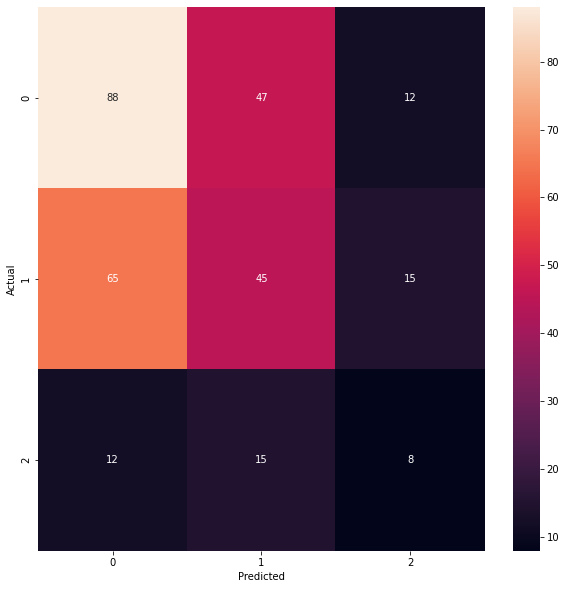

In [ ]:
#annalyzing the confusion matrix based on test data predictions
conf_matrix = confusion_matrix(np.argmax(to_categorical(data_test_node2.toxicity_bins), axis=1), y_pred_class_node2)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels = np.unique(data_test_node2.toxicity_bins), yticklabels = np.unique(y_pred_class_node2))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Option 2: TFIDF

In [ ]:
#creating a tfidf vecotrizer
tfidf2 = TfidfVectorizer(ngram_range = (1,3), max_features=10000)

X_train_node2 = tfidf2.fit_transform(data_train_node2.lemmatized_comment)
X_test_node2 = tfidf2.transform(data_test_node2.lemmatized_comment)

feature_names = tfidf2.get_feature_names()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
y_train_node2 = data_train_node2.toxicity_bins
y_test_node2 = data_test_node2.toxicity_bins

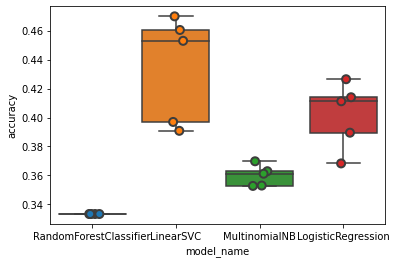

In [ ]:
#creating multiple models to compare performance on training data
models = [RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0), LinearSVC(), MultinomialNB(), LogisticRegression(random_state=0)]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train_node2, y_train_node2, scoring='balanced_accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()


In [ ]:
#once again, SVC is the winner
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.434215
LogisticRegression        0.401889
MultinomialNB             0.359914
RandomForestClassifier    0.333333
Name: accuracy, dtype: float64

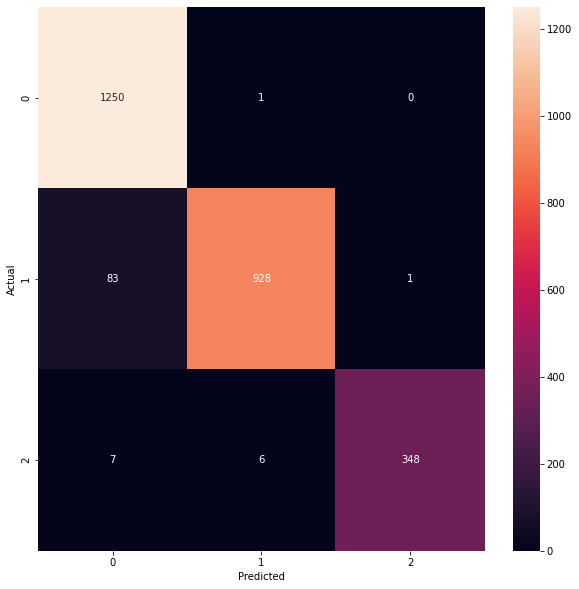

In [ ]:
#fitting the SVC model on the test dataset
svm = LinearSVC()
model = CalibratedClassifierCV(svm) 

model.fit(X_train_node2, y_train_node2)
y_pred = model.predict(X_train_node2)
y_pred_prob = model.predict_proba(X_train_node2)

conf_matrix = confusion_matrix(y_train_node2, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels = np.unique(y_train_node2), yticklabels = np.unique(y_pred))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

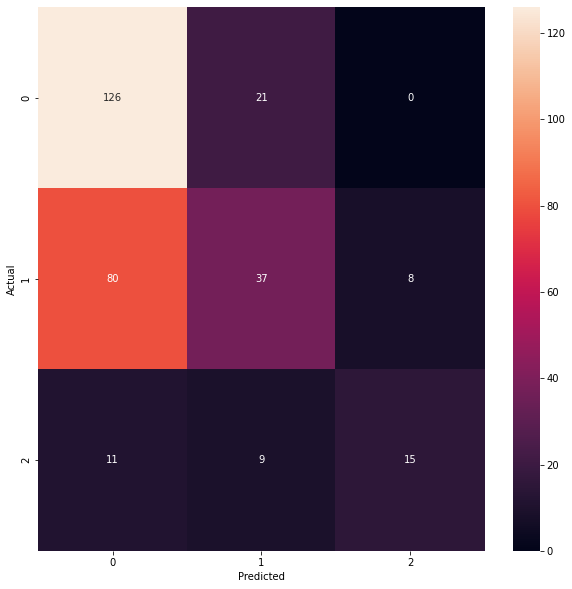

In [ ]:
#final solution on toxicity level classification
y_pred = model.predict(X_test_node2)
y_pred_prob = model.predict_proba(X_test_node2)

conf_matrix = confusion_matrix(y_test_node2, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels = np.unique(y_test_node2), yticklabels = np.unique(y_pred))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()